In [227]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
from jax.tree_util import (tree_flatten, tree_unflatten, treedef_is_leaf,
                           tree_map)

from jax.lax import fori_loop, while_loop, scan
from jax import jit

# Should be >=0.3.20 for `jax.debug` package
print(jax.__version__)

def fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val


def while_loop(cond_fun, body_fun, init_val):
    val = init_val
    while cond_fun(val):
        val = body_fun(val)
    return val


def scan(f, init, xs, length=None):
    xs_flat, xs_tree = tree_flatten(xs)
    carry = init
    ys = []
    length = len(xs_flat[0])
    for i in range(length):
        xs_slice = [x[i] for x in xs_flat]
        carry, y = f(carry, tree_unflatten(xs_tree, xs_slice))
        ys.append(y)
    stack = lambda *ys: jax.numpy.stack(ys)
    stacked_y = tree_map(stack, *ys)
    return carry, stacked_y

# test scan
def foo(carry, i):
    return (0, 0), (1, 2)

scan(foo, (0, 0), np.arange(10))
scan(foo, (0, 0), (np.arange(10), np.arange(20, 30)))

0.3.20


((0, 0),
 (DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32, weak_type=True),
  DeviceArray([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32, weak_type=True)))

In [228]:
tau_syn = 5e-3
tau_mem = 1e-2
t_late = tau_syn + tau_mem
t_max = 2 * t_late

tau_mem_inv = 1.0 / tau_mem
tau_syn_inv = 1.0 / tau_syn
v_th = 0.6
t_late = tau_syn + tau_mem
t_max = 2 * t_late

A = np.array([[-tau_mem_inv, tau_mem_inv], [0,-tau_syn_inv]])

def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)  # type: ignore

dynamics = partial(f, A)
batched_dynamics = jax.jit(jax.vmap(dynamics, in_axes=(0, None)))

In [229]:
y0 = np.array([0.0, 1.0])
xs = np.arange(0, t_max, 1e-4)
ys = jax.vmap(partial(dynamics, y0))(xs)

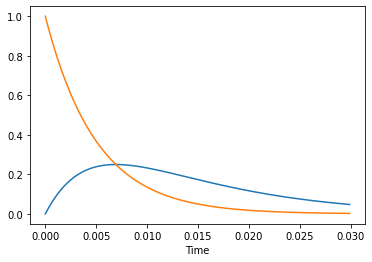

In [230]:
plt.xlabel('Time')
plt.plot(xs, ys)

In order to determine whether any jump had occured it is sufficient to focus on a given time interval $[t_k, t_{k+1}]$, we can then consider a jump condition $j$, for example one that is affine
$$j(t) = P y(t) - b$$
and do a root finding procedure on this interval.

In [231]:
# c.f.: https://github.com/google/jax/issues/8744
def newton(f, y0, x0):
  """Newton's method for root-finding."""
  initial_state = (0, x0)

  def cond(state):
    it, x = state
    return (it < 10)

  def body(state):
    it, x = state
    fx, dfx = f(y0, x), jax.grad(f, argnums=1)(y0, x)
    step = fx / dfx
    new_state = it + 1, x - step
    return new_state

  res = jax.lax.while_loop(
    cond,
    body,
    initial_state,
  )[1]
  return np.where(res > 0, res, np.nan)

In [232]:
# c.f.: https://github.com/google/jax/issues/8744

def newton(f, y0, initial_guess):
  """Newton's method for root-finding."""
  initial_state = (initial_guess)

  def body(x, it):
    fx, dfx = f(y0, x), jax.grad(f, argnums=1)(y0, x)
    step = fx / dfx
    return x - step, 0

  res = jax.lax.scan(body, initial_state, np.arange(6))[0]
  return np.where(res > 0, res, np.nan)

In [233]:
def ttfs(tau_mem, v_th, state, dt):
    """Find the next spike time for special case $\tau_mem = 2 * \tau_syn$"""
    v_0, i_0 = state
    a_1 = i_0
    a_2 = v_0 + i_0
    second_term = a_2**2 - 4 * a_1 * v_th
    has_spike = second_term > 0

    def true_fun():
        inner_log = 2 * a_1 / (a_2 + np.sqrt(second_term))
        return jax.lax.cond(
            inner_log > 1,
            lambda: tau_mem * np.log(inner_log),
            lambda: dt,
        )

    return jax.lax.cond(has_spike, true_fun, lambda: dt)

In [234]:
# check that nevative spike times return dt
dt = 0.1
ttfs_solver = partial(ttfs, tau_mem, v_th)
assert ttfs_solver(np.array([0.0, 0.1]), dt) == dt
assert ttfs_solver(np.array([0.0, -0.1]), dt) == dt
assert ttfs_solver(np.array([0.127, 0.0172]), dt) == dt
assert ttfs_solver(np.array([1.146776, 1.7953744]), dt) == dt

0.001


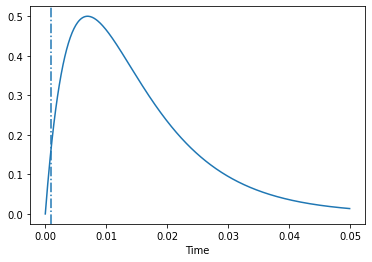

In [235]:
y0 = np.array([0.0, 2.0])
xs = np.arange(0, 5e-2, 1e-4)


def jump_condition(dynamics, v_th, x0, t):
  return dynamics(x0, t)[0] - v_th # this implements the P y(t) - b above


jc = partial(jump_condition, dynamics, v_th)
ys = jax.vmap(partial(dynamics, y0))(xs)[:, 0]

newton_solver = jax.jit(partial(newton, jc))


spike_time = newton_solver(y0, 1e-3)
spike_time = ttfs_solver(y0, 1e-3)

print(spike_time)

# %timeit newton_solver(y0, 1e-4)
# %timeit ttfs_solver(y0, 1e-4)

plt.xlabel('Time')
plt.plot(xs, ys)
plt.axvline(spike_time, linestyle='-.')

In [236]:
# let's wrap the newton solver with custom root

def custom_newton(f, initial_guess):
  """Newton's method for root-finding."""
  initial_state = (initial_guess)

  def body(x, it):
    fx, dfx = f(x), jax.grad(f)(x)
    step = fx / dfx
    return x - step, 0

  res = jax.lax.scan(body, initial_state, np.arange(6))[0]
  return np.where(res > 0, res, np.nan)


def tangent_solve(g, y):
    return y / g(1.0)

solve = custom_newton

@jax.jit
def wrapped_newton_solver(y0, initial_guess):
    f = partial(jc, y0)
    return jax.lax.custom_root(f, initial_guess, solve, tangent_solve)

In [237]:
# do this for two neurons
y0 = np.array([[0.0, 1.0], [0.1, 1.0], [0.0, 0.0]])
batched_newton_solver = jax.jit(jax.vmap(newton_solver, in_axes=(0, None)))
batched_wrapped_newton_solver = jax.jit(jax.vmap(wrapped_newton_solver, in_axes=(0, None)))
batched_ttfs_solver = jax.jit(jax.vmap(ttfs_solver, in_axes=(0, None)))

spike_times = batched_ttfs_solver(y0, 1e-4)
print(spike_times)
# %timeit batched_newton_solver(y0, 1e-4)
# %timeit batched_wrapped_newton_solver(y0, 1e-4)
# %timeit batched_ttfs_solver(y0, 1e-4).block_until_ready()

[1.e-04 1.e-04 1.e-04]


In [238]:
# but how can we feed input spikes into the net?
# we start with maximal one input spike per layer
y0 = np.array([[0.0, 0.0], [0.0, 0.2], [0.0, 0.0]])
input_spikes = np.array([1e-3, 3e-2, np.inf])

t_spike = batched_ttfs_solver(y0, t_max)
print(f"Next spike at: {np.min(t_spike)}")

t_spike = np.where(np.isnan(t_spike), np.inf, t_spike)
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")

# but we only want to take input spikes that are still in the future
# suppose our current time is t
t = 2e-3
input_spikes = np.where(input_spikes > t, input_spikes, np.inf)  
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")

# this also works. But what is returned if no next spike is coming up?
t = 5e-3
input_spikes = np.where(input_spikes > t, input_spikes, np.inf)  
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")


Next spike at: 0.029999999329447746
Next spike from neuron 0 at 0.0010000000474974513
Next spike from neuron 0 at 0.029999999329447746
Next spike from neuron 0 at 0.029999999329447746


Now define multiple simple datasets

In [218]:
def toy_dataset(iterations):
    input = np.tile(np.array([0, 0.5]), (iterations, 1)) * t_late
    target = np.tile(np.array([1.0, 1.5]), (iterations, 1)) * t_late
    return (input, target)

def one_hot(x):
    return np.array(x[:, None] == np.arange(2), np.float32)

def linear_dataset(rng, iterations):
    input = jax.random.uniform(rng, (iterations, 2))
    which_class = (input[:, 0] < input[:, 1]).astype(int)
    encoding = np.array([[0, 1], [1, 0]]) * t_max  

    # augment dataset
    input = np.hstack((input, 1 - input)) 
    input = input * t_late  
    return (input, encoding[which_class])

def circle_dataset(rng, iterations):
    input = jax.random.uniform(rng, (iterations, 2))
    radius = np.sqrt(0.5 / np.pi)  # spread classes equal
    center = (0.5, 0.5)
    which_class = ((input[:, 0] - center[0]) ** 2 + (input[:, 1] - center[1]) ** 2 <= radius**2).astype(int)
    encoding = np.array([[0, 1], [1, 0]]) * t_max  

    # augment dataset
    input = np.hstack((input, 1 - input)) 
    input = input * t_late  
    return (input, encoding[which_class])

(4,)
Max Voltage: [ 2.8949022  4.0869756  0.8110666 11.332593 ]


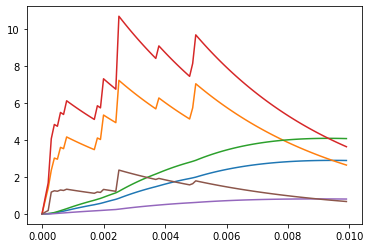

In [219]:
@jax.jit
def li_cell(weights, spikes, ts):
    spike_times, spike_idx = spikes

    current = weights[spike_idx] * np.where(spike_idx == -1, 0.0, 1.0)
    voltage = np.zeros(len(spike_idx))
    xk = np.stack((voltage, current), axis=1)  

    def heaviside(x):
        return 0.5 + 0.5 * np.sign(x)

    def kernel(A, t, t0):
        return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))  # type: ignore

    def f(A, t0, x0, t):
        return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, A, t))(t0), x0)
    
    ys = jax.jit(jax.vmap(partial(f, A, spike_times, xk)))(ts)
    return ys

leaky_integrator = jax.vmap(li_cell, in_axes=(1, None, None), out_axes=1)

rng = jax.random.PRNGKey(42)
rng, times_rng, idx_rng, weight_rng = jax.random.split(rng, 4)
spike_times = jax.random.uniform(times_rng, (20,)) * 5e-3
spike_idx = jax.random.randint(idx_rng, (20,), 0, 5) - 1
weights = jax.random.normal(weight_rng, (2, 4)) + 1.5
ts = np.arange(0, 1e-2, 1e-4)
trace = leaky_integrator(weights, (spike_times, spike_idx), ts)
max_voltage = np.max(trace[:,:,0], axis=0)
print(max_voltage.shape)
print(f"Max Voltage: {max_voltage}")
plt.plot(ts, trace[:, 0, :])
plt.plot(ts, trace[:, 1, :])
plt.plot(ts, trace[:, 2, :])
plt.show()

In [220]:
@jax.jit
def nll_loss(x, targets):
    x = np.maximum(x, 0)
    preds = jax.nn.log_softmax(x)
    loss = -np.sum(targets * preds)
    return loss

def max_over_time_loss(weights, spikes, targets):
    # T = 100
    # ts = np.linspace(0, t_max, T)
    output = leaky_integrator(weights, spikes, np.array([t_max]))
    last_voltage = output[0,:,0]
    loss_value = nll_loss(last_voltage, targets)
    acc_value = np.sum(np.argmax(last_voltage) == np.argmax(targets))
    return loss_value, acc_value, last_voltage

# @jax.jit
def loss_fn(weights, batch):
    input_spikes, targets = batch
    y_new, spikes = forward(weights[:2], input_spikes, t_max)
    loss, acc, max_v = max_over_time_loss(weights[2], spikes, targets)
    return loss, (acc, spikes, max_v)


def update(weights, batch):
    value, grad = jax.value_and_grad(loss_fn, has_aux=True)(weights, batch)
    lr = 0.1
    scaling = [1 / tau_mem, 1 / tau_mem, 1]
    weights = [w - lr * g * s for w, g, s, in zip(weights, grad, scaling)]
    return weights, value

def init_weights(rng, n_input, n_hidden, n_output):
    scaling = 1.0
    input_rng, hidden_rng, output_rng = jax.random.split(rng, 3)
    input_weights = jax.random.uniform(input_rng, (n_input, n_hidden)) * scaling
    recurrent_weights = jax.random.normal(hidden_rng, (n_hidden, n_hidden)) * (1 - np.eye(n_hidden)) * scaling  
    output_weights = jax.random.normal(output_rng, (n_hidden, n_output)) * scaling

    return [input_weights, recurrent_weights, output_weights]

def linear_dataset(rng, iterations):
    input = jax.random.uniform(rng, (iterations // 10, 2))
    # ten epochs
    input = np.tile(input, (10, 1))
    which_class = (input[:, 0] < input[:, 1]).astype(int)
    encoding = np.array([[0, 1], [1, 0]])

    # augment dataset
    input = np.hstack((input, 1 - input)) 
    input = input * t_late  
    return (input, encoding[which_class])

Loss: 0.797, acc: 0.410
Loss: 0.675, acc: 0.590
Switched weights - Loss: 0.738, acc: 0.410


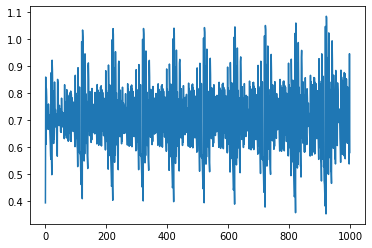

In [32]:
n_input = 4
n_hidden = 4
n_output = 2
batch_size = 100

rng = jax.random.PRNGKey(42)
rng, train_rng, test_rng = jax.random.split(rng, 3)

weights = init_weights(rng, n_input, n_hidden, n_output)
step_fn = partial(step, batched_dynamics, batched_ttfs_solver)

testset = linear_dataset(test_rng, 1_000)
trainset = linear_dataset(train_rng, 1_000)

def make_batches(dataset, batch_size):
    return (dataset[0].reshape(-1, batch_size, 4), dataset[1].reshape(-1, batch_size, 2))

test_loss, (test_acc, spikes, max_v) = jax.vmap(loss_fn, in_axes=(None, 0))(weights, testset)
print(f"Loss: {np.mean(test_loss):.3f}, acc: {np.mean(test_acc):.3f}")

# loss_value = []
# for i in range(len(testset[0])):
#     weights, (loss, (acc, spikes, max_v)) = update(weights, (trainset[0][i], trainset[1][i]))
#     loss_value.append(loss)

weights, (loss_value, (acc, spikes, max_v)) = jax.lax.scan(update, weights, (trainset[0][:10_000], trainset[1][:10_000]))

test_loss, (test_acc, _, _) = jax.vmap(loss_fn, in_axes=(None, 0))(weights, testset)
print(f"Loss: {np.mean(test_loss):.3f}, acc: {np.mean(test_acc):.3f}")

switched_weights = [weights[0], weights[1], np.stack((weights[2][:, 1], weights[2][:, 0]), axis=1)]
test_loss, (test_acc, _, _) = jax.vmap(loss_fn, in_axes=(None, 0))(switched_weights, testset)
print(f"Switched weights - Loss: {np.mean(test_loss):.3f}, acc: {np.mean(test_acc):.3f}")

plt.plot(np.arange(len(loss_value)), loss_value)
plt.show()

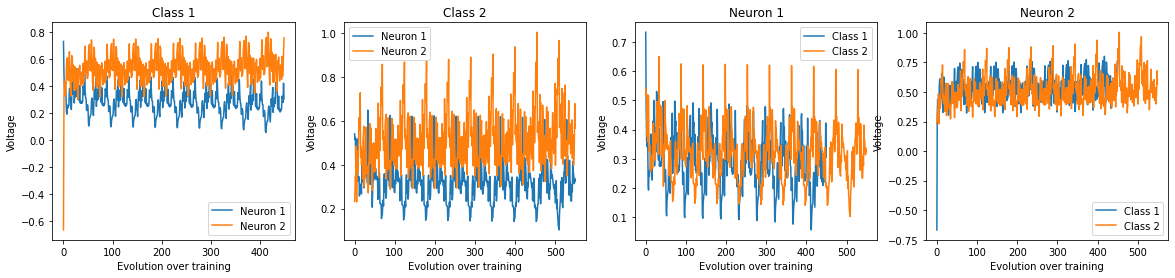

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
which_class = np.argmax(trainset[1], axis=1)
ax1.plot(max_v[which_class == 0][:, 0], label="Neuron 1")
ax1.plot(max_v[which_class == 0][:, 1], label="Neuron 2")
ax1.set_xlabel("Evolution over training")
ax1.set_ylabel("Voltage")
ax1.set_title("Class 1")
ax1.legend()

ax2.plot(max_v[which_class == 1][:, 0], label="Neuron 1")
ax2.plot(max_v[which_class == 1][:, 1], label="Neuron 2")
ax2.set_xlabel("Evolution over training")
ax2.set_ylabel("Voltage")
ax2.set_title("Class 2")
ax2.legend()

ax3.plot(max_v[which_class == 0][:, 0], label="Class 1")
ax3.plot(max_v[which_class == 1][:, 0], label="Class 2")
ax3.set_xlabel("Evolution over training")
ax3.set_ylabel("Voltage")
ax3.set_title("Neuron 1")
ax3.legend()

ax4.plot(max_v[which_class == 0][:, 1], label="Class 1")
ax4.plot(max_v[which_class == 1][:, 1], label="Class 2")
ax4.set_xlabel("Evolution over training")
ax4.set_ylabel("Voltage")
ax4.set_title("Neuron 2")
ax4.legend()

plt.show()

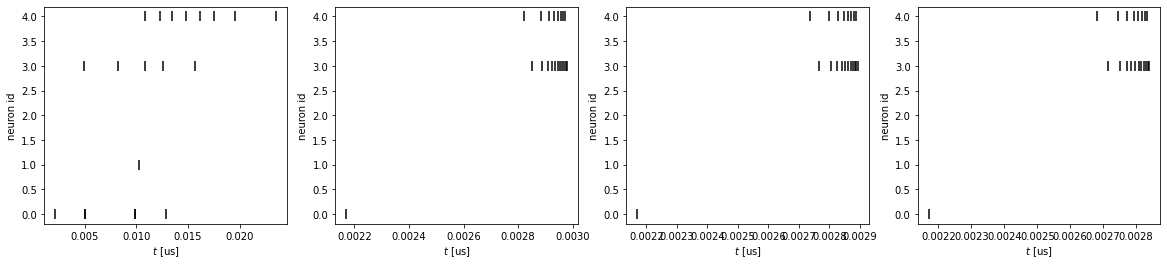

In [36]:
def plot_spike_times(spikes):
    spike_times, spike_idx = spikes
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for i in range(4):
        it = i * 200
        spike_times = spikes[0][it]
        spike_idx = spikes[1][it]
        axs[i].scatter(
            x=spike_times,
            y=spike_idx + 1,
            s=3*(120. / len(spike_times)) ** 2.,
            marker="|",
            c="black",
        )
        axs[i].set_ylabel("neuron id")
        axs[i].set_xlabel(r"$t$ [us]")
    plt.show()

plot_spike_times(spikes)

In [221]:
import os
import sys

nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from jaxsnn.types import Array, Spike

In [242]:
from typing import Callable, Tuple, NamedTuple


class StepState(NamedTuple):
    neuron_state: Array
    time: float
    running_idx: int


def transition_fn(
    state: StepState,
    weights: Tuple[Array, Array],
    input_spikes: Spike,
    spike_idx: int,
    recurrent_spike: bool,
) -> StepState:
    # transition
    y_minus, t, running_idx = state
    input_weights, recurrent_weights = weights
    tr_row = jax.lax.cond(
        recurrent_spike,
        lambda: recurrent_weights[spike_idx],
        lambda: input_weights[input_spikes.idx[running_idx]],
    )
    y_minus = y_minus.at[:, 1].set(y_minus[:, 1] + tr_row)

    # # reset
    y_minus, running_idx = jax.lax.cond(
        recurrent_spike,
        lambda: (y_minus.at[spike_idx, 0].set(0.0), running_idx),
        lambda: (y_minus, running_idx + 1),
    )
    return StepState(y_minus, t, running_idx)


def step(
    dynamics: Callable,
    solver: Callable,
    tr_dynamics: Callable,
    t_max: float,
    weights: Tuple[Array, Array],
    input_spikes: Spike,
    state: StepState,
    epoch: int,
) -> Tuple[Array, Spike]:
    y, t, running_idx = state
    pred_spikes = solver(y, t_max - t) + t
    spike_idx = np.argmin(pred_spikes)

    # integrate state
    t_dyn = np.min(np.array([pred_spikes[spike_idx], input_spikes.time[running_idx], t_max]))
    state = StepState(dynamics(y, t_dyn - t), t_dyn, running_idx)

    no_spike = t_dyn == t_max
    recurrent_spike = pred_spikes[spike_idx] < input_spikes.time[running_idx]

    transitioned_state = jax.lax.cond(
        no_spike,
        lambda *args: state,
        tr_dynamics,
        state,
        weights,
        input_spikes,
        spike_idx,
        recurrent_spike,
    )

    stored_idx = jax.lax.cond(recurrent_spike, lambda: spike_idx, lambda: -1)
    return transitioned_state, Spike(t_dyn, stored_idx)


In [246]:
def Net(n_input, n_hidden, n_spikes):
    step_fn = partial(step, batched_dynamics, batched_ttfs_solver, transition_fn, t_max)

    def init_fn(rng):
        scale_factor = 2.0
        input_rng, hidden_rng = jax.random.split(rng)
        input_weights = jax.random.uniform(input_rng, (n_input, n_hidden)) * scale_factor
        recurrent_weights = (
            jax.random.uniform(hidden_rng, (n_hidden, n_hidden))
            * (1 - np.eye(n_hidden))
            * scale_factor
        )
        return (input_weights, recurrent_weights)

    def apply_fn(weights, input_spikes) -> Spike:
        state = StepState(np.zeros((n_hidden, 2)), 0, 0)
        (state, spikes) = jax.lax.scan(partial(step_fn, weights, input_spikes), state, np.arange(n_spikes))  # type: ignore   
        return spikes

    return init_fn, apply_fn

In [249]:
def log_loss(first_spikes, target):
    loss_value = -np.sum(np.log(1 + np.exp(-np.abs(first_spikes - target) / tau_mem)))
    return loss_value


def loss_fn(apply_fn, weights, batch):
    input_spikes, target = batch
    spikes = apply_fn(weights, input_spikes)
    time1 = np.nanmin(np.where(spikes.idx == 3, spikes.time, np.nan))
    time2 = np.nanmin(np.where(spikes.idx == 1, spikes.time, np.nan))

    return (
        log_loss(np.array([time1, time2]), target),
        (np.array([time1, time2]), spikes),
    )


def update_fn(loss_fn, weights, batch):
    value, grads = jax.value_and_grad(loss_fn, has_aux=True)(weights, batch)
    weights = jax.tree_map(lambda f, df: f - 0.1 * df, weights, grads)
    return weights, value


def train(trainset):
    rng = jax.random.PRNGKey(42)
    n_input = 2
    n_hidden = 4
    n_spikes = 10
    init_fn, apply_fn = Net(n_input, n_hidden, n_spikes)
    weights = init_fn(rng)
    
    update = partial(update_fn, partial(loss_fn, apply_fn))
    weights, (loss, (t_output, spikes)) = jax.lax.scan(update, weights, trainset)

    fix, (ax1, ax2) = plt.subplots(2, 4, figsize=(18, 6))
    ax1[0].plot(np.arange(len(loss)), loss, label="Loss")
    ax1[1].plot(np.arange(len(t_output)), t_output[:, 0] / t_max, label="t_spike 1")
    ax1[1].plot(np.arange(len(t_output)), t_output[:, 1] / t_max, label="t_spike 2")
    ax1[1].legend()
    # plot_spike_times(spikes, ax2)
    plt.show()

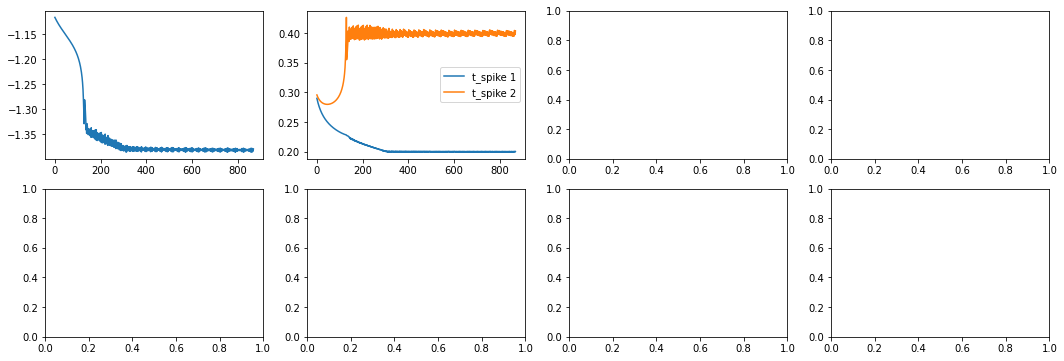

In [250]:
def constant_dataset(n_epochs):
    input_spikes = Spike(
    np.array([0.1, 0.2, 1]) * t_max,  # type: ignore
    np.array([0, 1, 0]),
    )
    target = np.array([0.2, 0.4]) * t_max  # type: ignore
    batch = (input_spikes, target)
    tiling = (n_epochs, 1)
    dataset = (
        Spike(
            np.tile(batch[0].time, tiling), np.tile(batch[0].idx, tiling)
        ),
        np.tile(batch[1], tiling),
    )
    return dataset

n_epochs = 1000
trainset = constant_dataset(n_epochs)
train(trainset)

In [ ]:
# how would this work on a linear dataset?
def linear_dataset(rng, iterations):
    input = jax.random.uniform(rng, (iterations // 10, 2))
    # ten epochs
    input = np.tile(input, (10, 1))
    which_class = (input[:, 0] < input[:, 1]).astype(int)
    encoding = np.array([[0, 1], [1, 0]])

    # augment dataset
    input = np.hstack((input, 1 - input)) 
    input = input * t_late  
    return (input, encoding[which_class])